# Проект: классификация

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder,OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Используемые функции
# функция по обработке выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, round(lower_bound),round(upper_bound)

def get_age_category(age):
    if age < 30:
        age_category = '<30'
    elif 30 <= age < 40:
        age_category = '30-40'
    elif 40 <= age < 50:
        age_category = '40-50'
    elif 50 <= age < 60:
        age_category = '50-60'
    else:
        age_category = '60+'
    return age_category

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.unique().tolist()

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_copy = df.copy()
df_copy['balance'] = df_copy['balance'].apply(lambda x: str(x).replace(',','.').replace('$','').replace(' ',''))
df_copy['balance'] = df_copy['balance'].astype('float')
df_copy['balance'].mean().round(3)

1529.129

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

values = {
    'balance': df_copy['balance'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
df_copy = df_copy.fillna(values)
df_copy['balance'].mean().round(3)

1526.936

### Задание 5

In [31]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df_copy['job'].mode()

df_copy['job'] = np.where(df_copy['job']=='unknown', df_copy['job'].mode(),df_copy['job'])
df_copy['education'] = np.where(df_copy['education']=='unknown', df_copy['education'].mode(),df_copy['education'])


In [32]:
mask1 = df_copy['education']=="secondary"
mask2 = df_copy['job']=="management"

df_copy[mask1 & mask2]['balance'].mean().round(3)

1598.883

### Задание 6

In [33]:
# удалите все выбросы для признака balance
# ваш код
outliers, cleaned,lower_bound,upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')



Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241
Нижняя граница: 4063


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

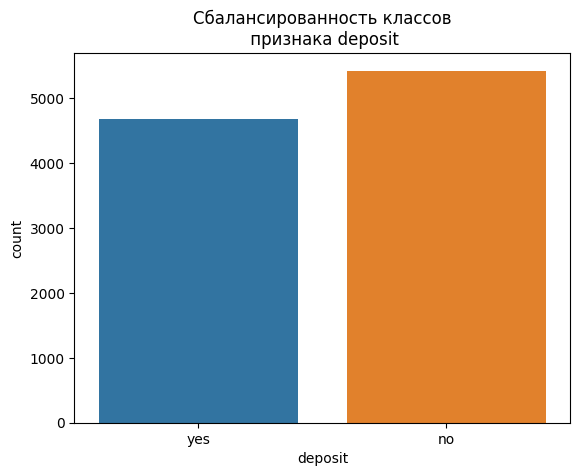

In [34]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(cleaned.deposit.value_counts())
dep = sns.countplot(data=cleaned, x="deposit", hue='deposit');
dep.set_title('Сбалансированность классов\n признака deposit');

Можно сказать что классы в целевой переменной почти сбалансированы, но для точности моделирования я все же предпочту использовать параметр `stratify`

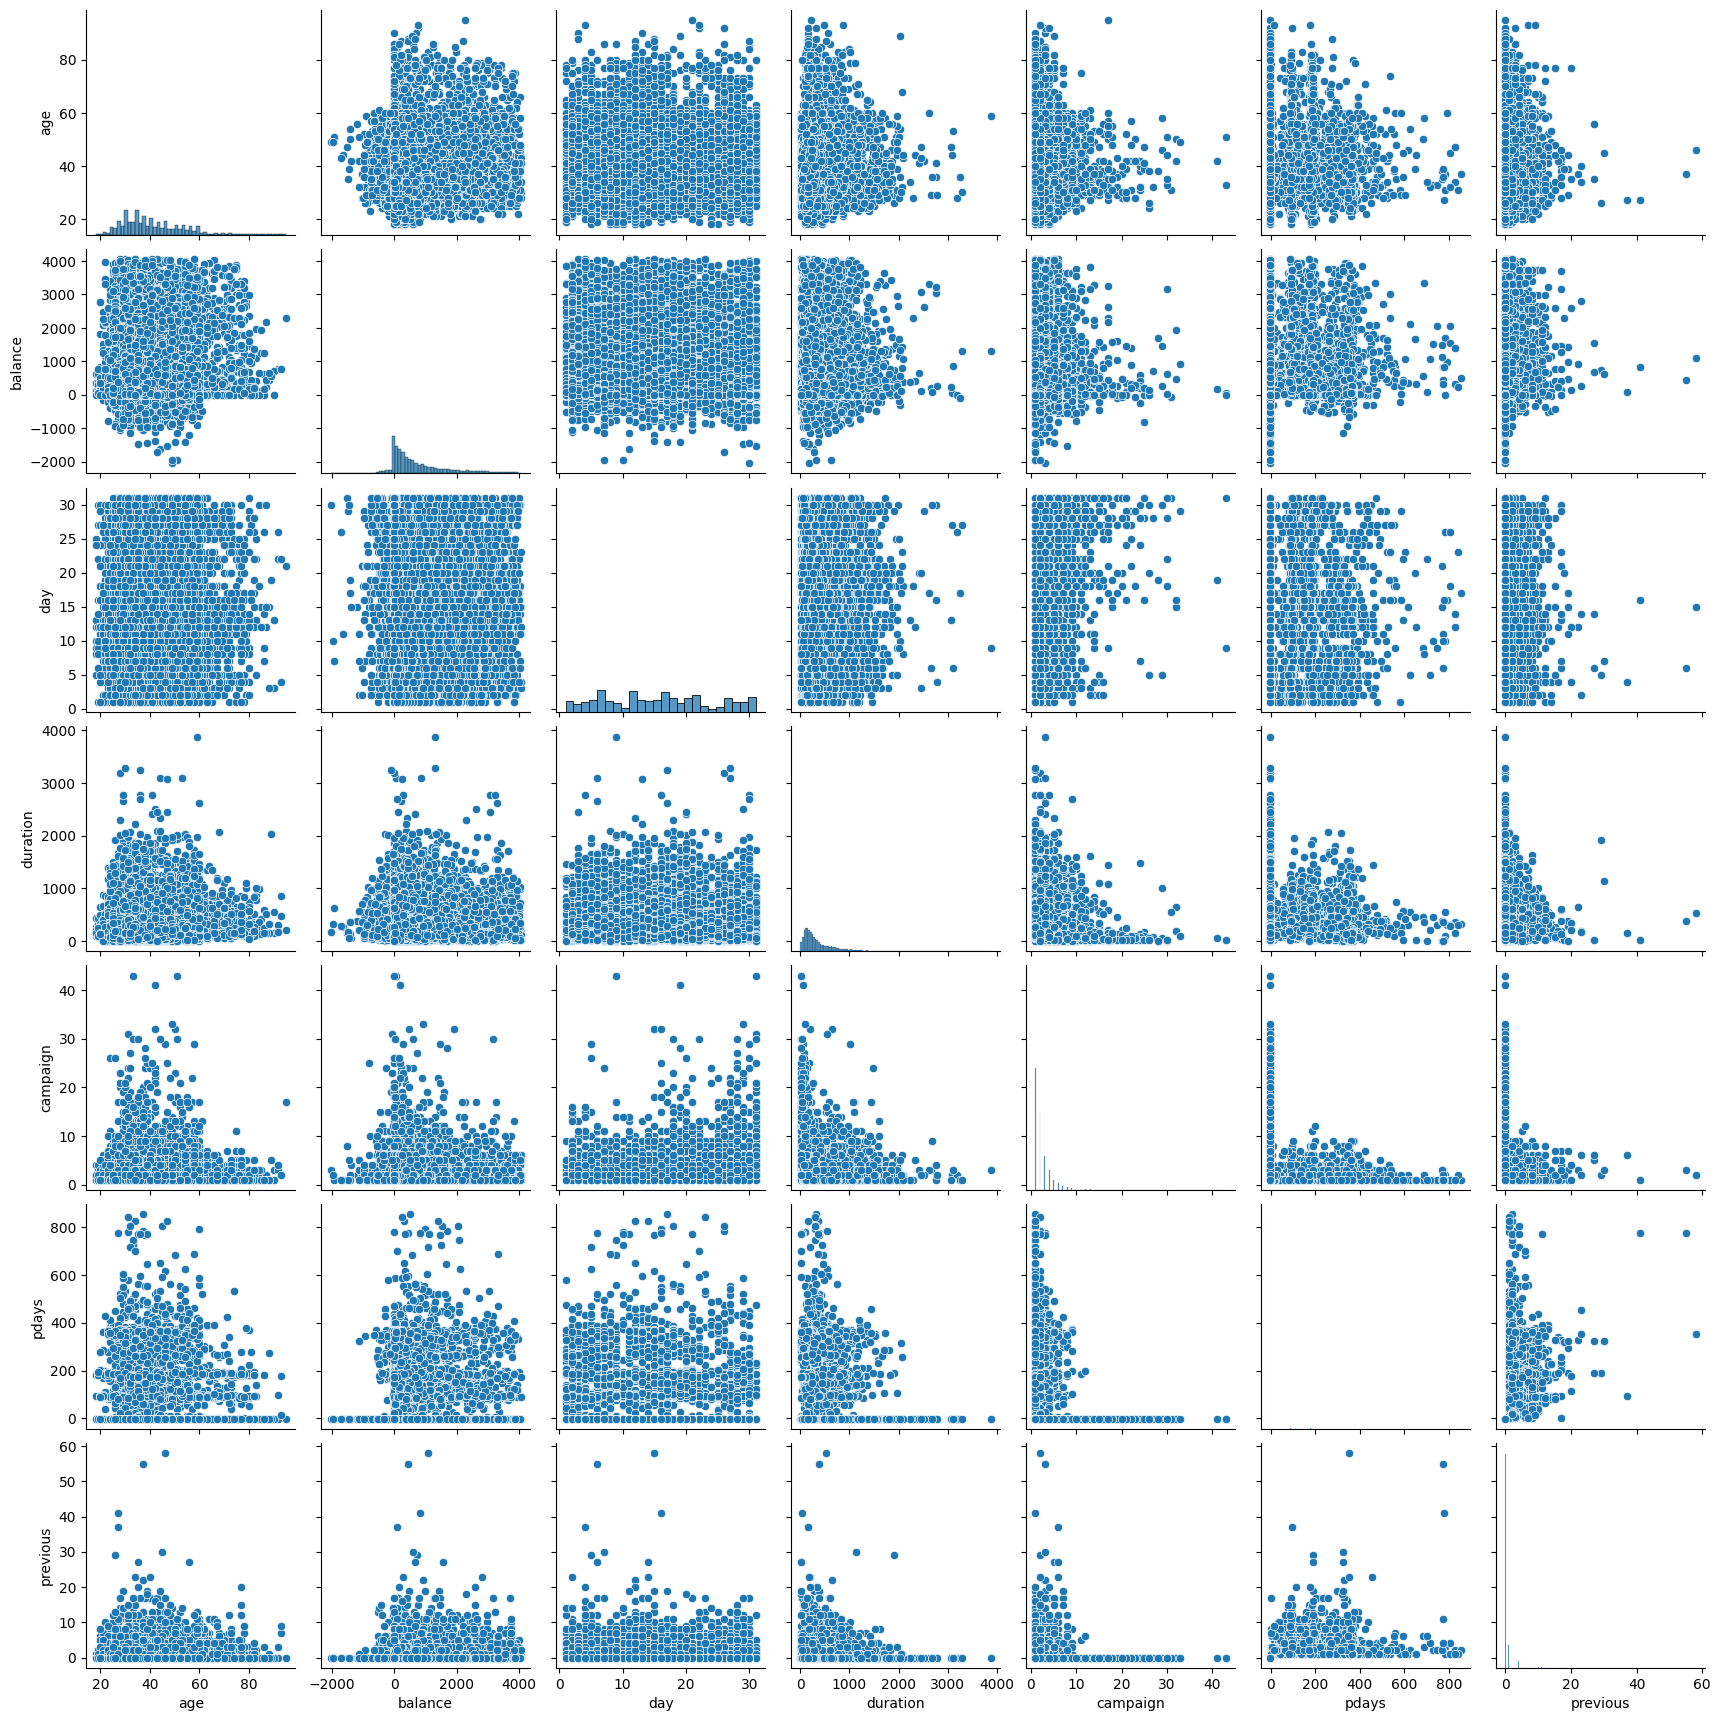

In [ ]:
sns.pairplot(data=cleaned);

### Задания 2 и 3

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


* Признак `age` -  наличие выбросов в максимальных значениях, хотя отличие среднего от медианы всего два года<br>
* Признак `duration` -  наличие выбросов в максимальных значениях, хотя отличие среднего от медианы всего два года<br>
* Признак `age` - явно наличие выбросов в максимальных значениях, хотя отличие среднего от медианы всего два года<br>

In [13]:
numeric_features = cleaned.describe().columns.tolist()

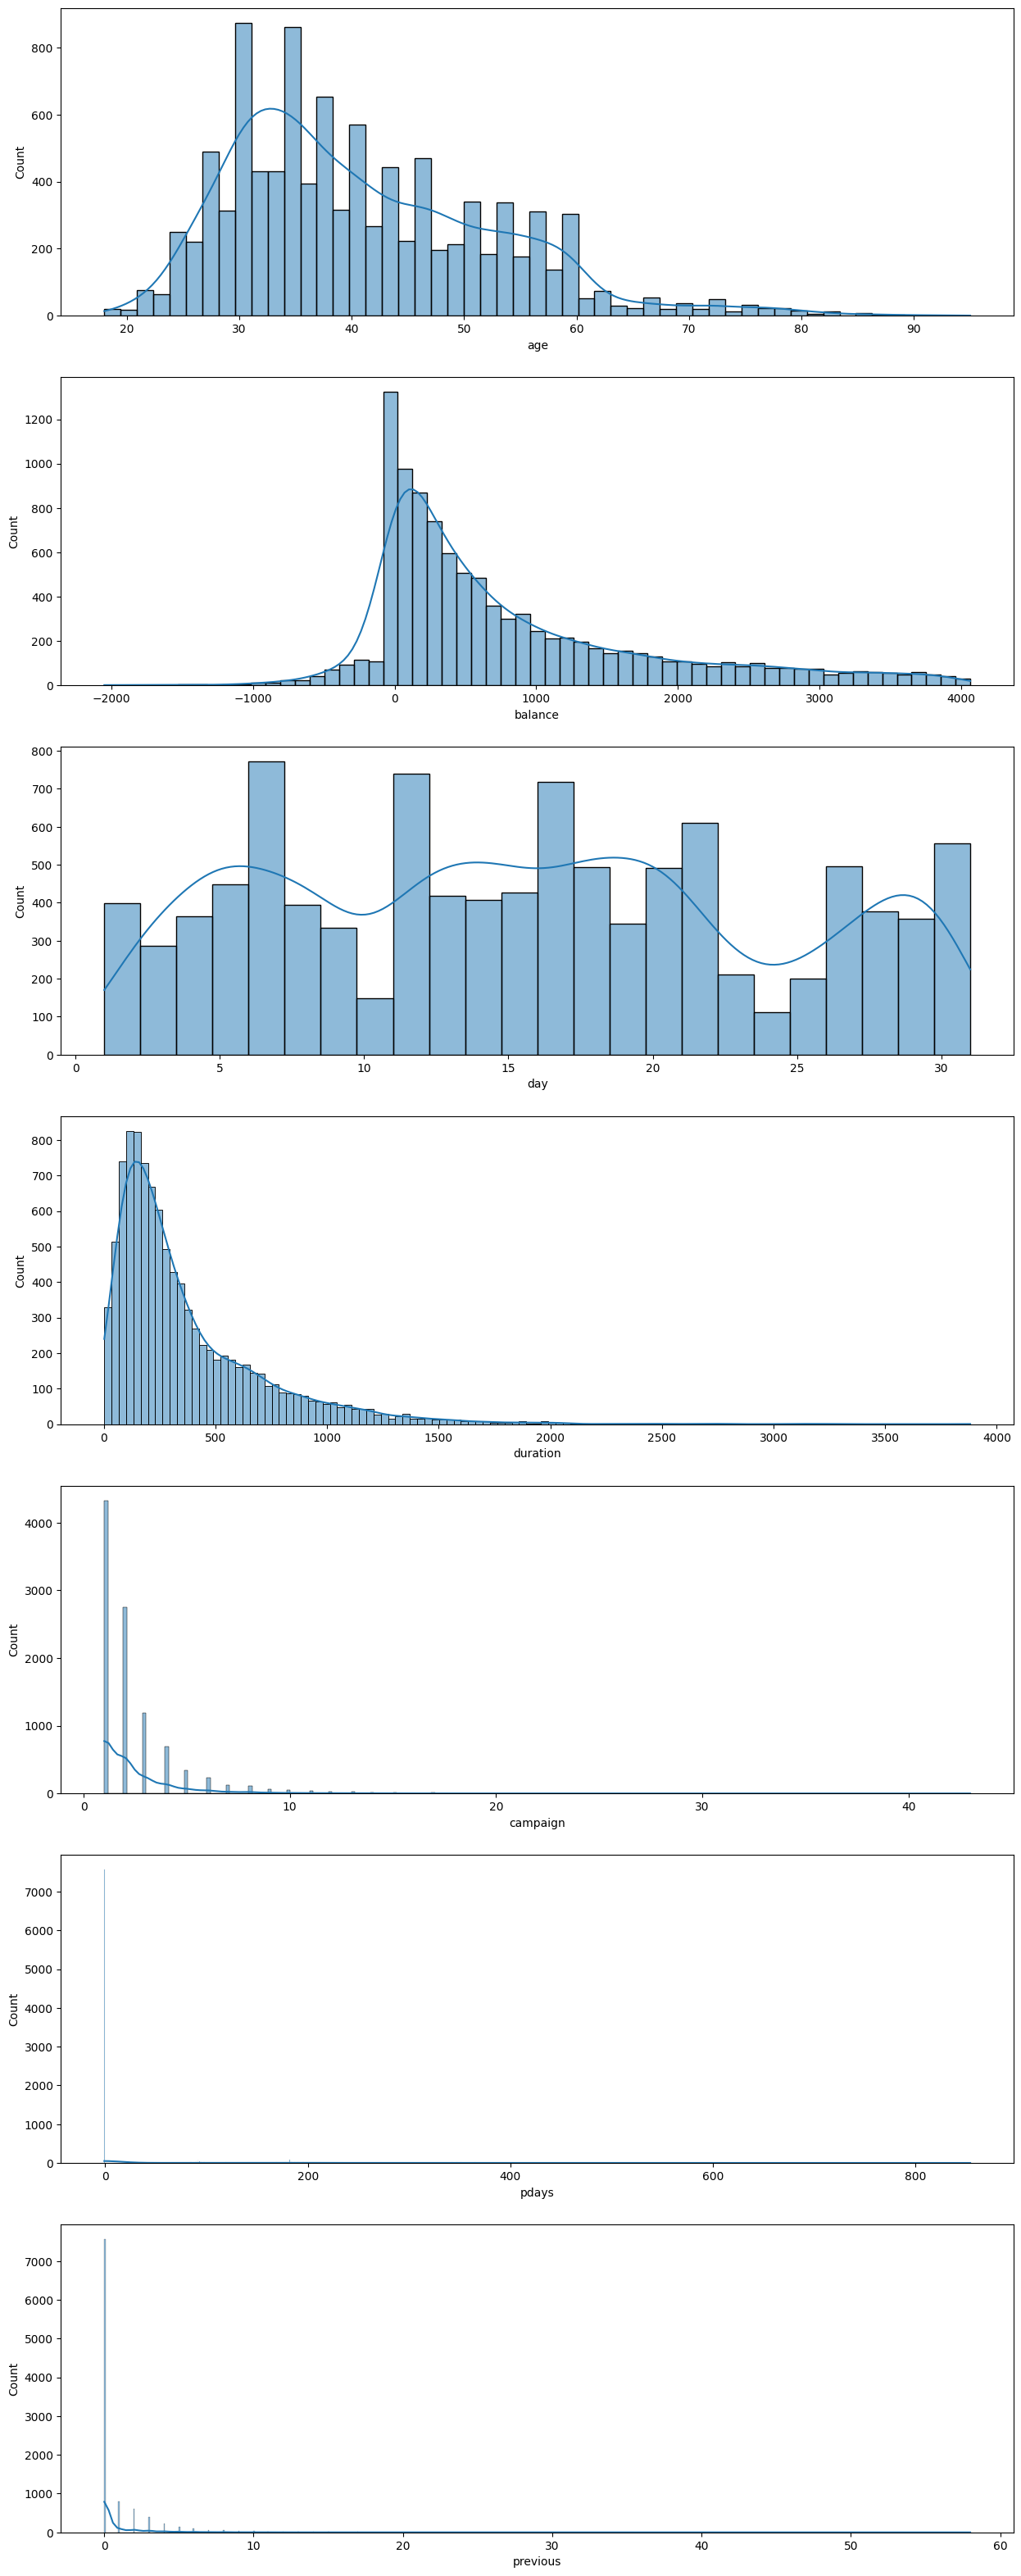

In [14]:

numeric_features = cleaned.describe().columns.tolist()
n = len(numeric_features)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(15, 40))
for i,feature in enumerate(numeric_features):
    sns.histplot(cleaned, x=feature, ax=axes[i], kde=True)
    

* Визуализация на скорую руку, не дала особого представления о признаках `pervious`,`pdays`,`campaign`. * 
* Можно предположить что распределения `age`, `balance` признаков можно отнести к логнормальным (с натяжкой конечно же).
* Распределение признака `duration` можно отнести к логнормальному, а также что количество клиентов с отрицательным балансом меньше чем с положительным.
* Можно попробовать создать признак положительного баланса `positive_balance`, но после создания стоит сличить его с признаками наличия кредитов, проверить на наличие мультиколлинеарности.

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5078,9939,5243,8712,7283,2617,7570,5424


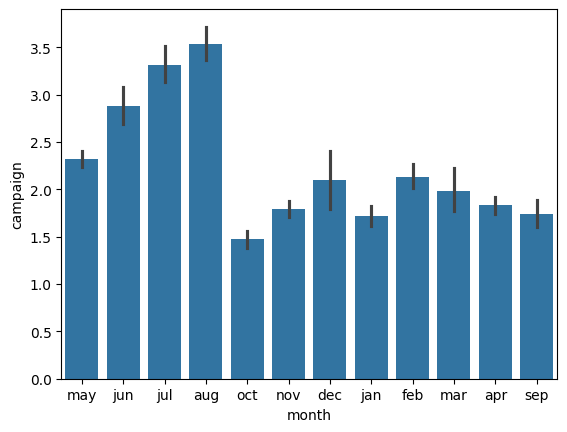

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
display(cleaned.describe(include= 'object'))
sns.barplot(data=cleaned, x='month', y='campaign');

In [16]:
cleaned.poutcome.value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

### Задание 6

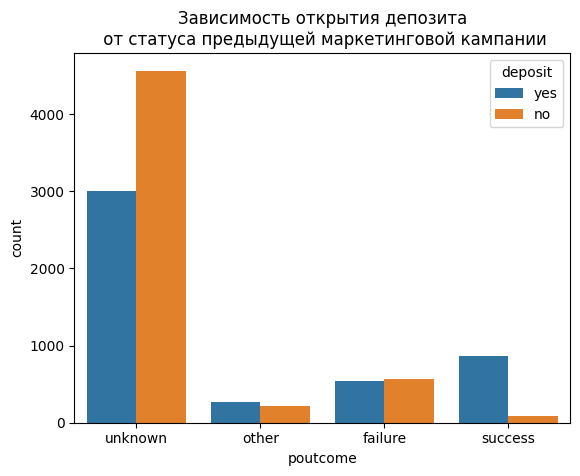

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
pout = sns.countplot(data=cleaned, x='poutcome', hue='deposit');
pout.set_title('Зависимость открытия депозита\n от статуса предыдущей маркетинговой кампании');


### Задание 7

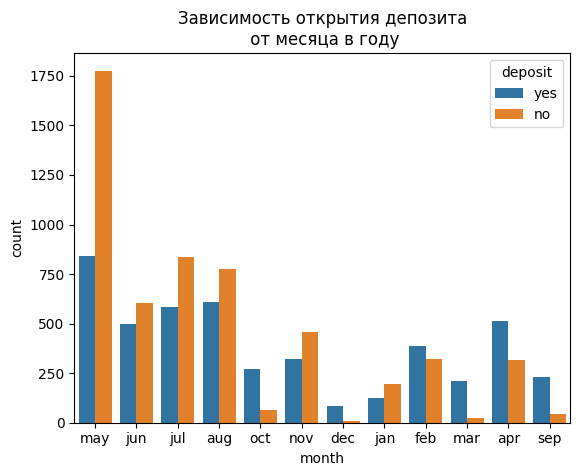

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month = sns.countplot(data=cleaned, x='month', hue='deposit');
month.set_title('Зависимость открытия депозита\n от месяца в году');

### Задание 8

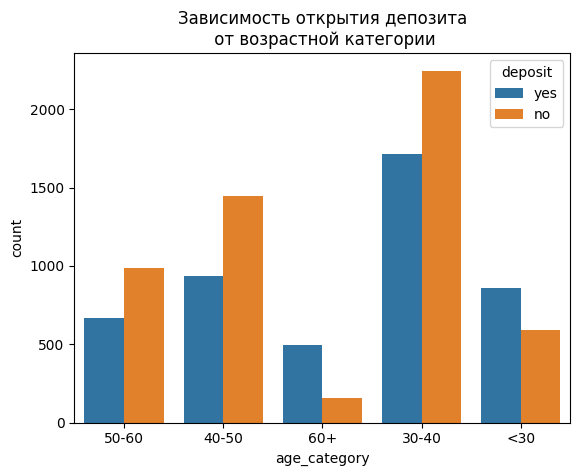

In [41]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_category'] = cleaned['age'].apply(get_age_category)

age = sns.countplot(data=cleaned, x='age_category', hue='deposit');
age.set_title('Зависимость открытия депозита\n от возрастной категории');

### Задания 9 и 10

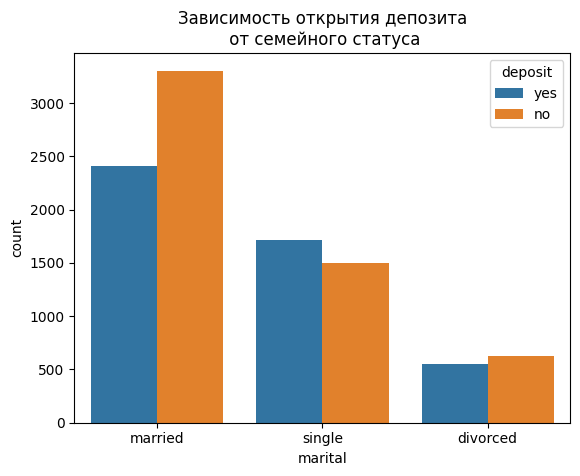

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital = sns.countplot(data=cleaned, x='marital', hue='deposit');
marital.set_title('Зависимость открытия депозита\n от семейного статуса');

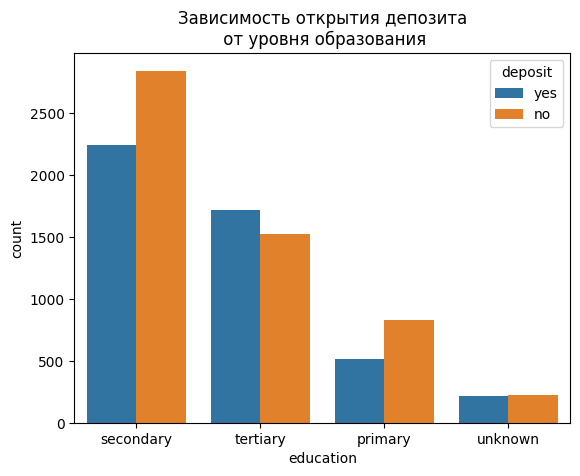

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ed = sns.countplot(data=cleaned, x='education', hue='deposit');
ed.set_title('Зависимость открытия депозита\n от уровня образования');

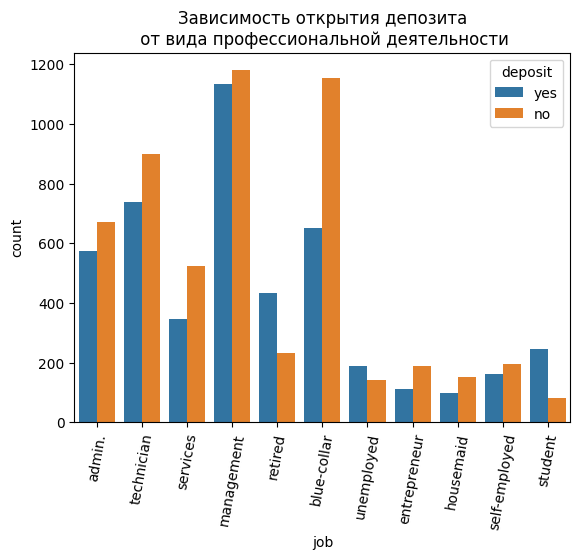

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job = sns.countplot(data=cleaned, x='job', hue='deposit');
job.xaxis.set_tick_params(rotation=80)
job.set_title('Зависимость открытия депозита\n от вида профессиональной деятельности');

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,265,1169,805
tertiary,174,784,755
unknown,18,120,74


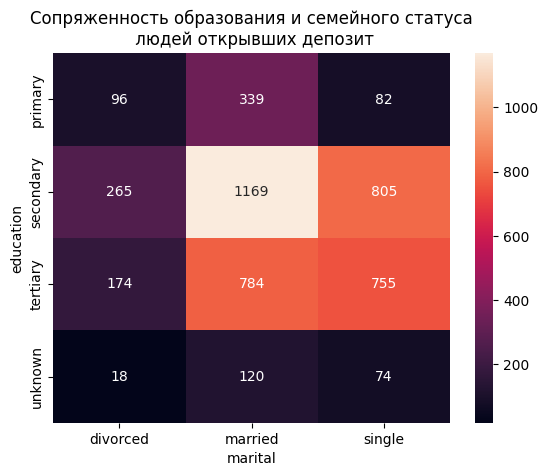

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

deposit_yes = cleaned[cleaned['deposit']=='yes']
cross_table = pd.crosstab(deposit_yes.education, deposit_yes.marital)
display(cross_table)
heat_cross = sns.heatmap(data=cross_table, annot=True, fmt= ".0f");
heat_cross.set_title('Сопряженность образования и семейного статуса\n людей открывших депозит');

## Часть 3: преобразование данных

### Задание 1

In [35]:
cleaned.education.value_counts()

education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64

In [39]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [45]:
# преобразуйте уровни образования

#инициализируем кодировщик
encoder_le = LabelEncoder()

# трансформируем признак образования
cleaned.education = encoder_le.fit_transform(cleaned.education)

# проверяем значения
display(cleaned.education.value_counts())

# отвечаем на котнтрольный вопрос 
print('Сумма значений в закодированном признаке "education":{:.0f}'.format(cleaned.education.sum()))

# трансформируем признак категории возраста
cleaned.age_category = encoder_le.fit_transform(cleaned.age_category)
# проверяем значения
display(cleaned.age_category.value_counts())



education
1    5517
2    3239
0    1349
Name: count, dtype: int64

Сумма значений в закодированном признаке "education":11995


age_category
0    3961
1    2382
2    1654
4    1455
3     653
Name: count, dtype: int64

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц
for feature in cleaned.columns:
    if len(cleaned[feature].unique()) <=2:
        cleaned[feature] = cleaned[feature].apply(lambda x: 0 if x=='no'else 1)

print('Cтандартное отклонение в признаке "deposit":{:.3f}'.format(cleaned.deposit.std()))

,job,marital,contact,month,poutcome
count,10105,10105,10105,10105,10105
unique,11,3,3,12,4
top,management,married,cellular,may,unknown
freq,2315,5715,7283,2617,7570


In [ ]:
cols = ['loan','housing','default']
summ = []
for col in cleaned[cols]:
    summ.append(cleaned[col].mean())
print('Cумма средних признаков из списка cols:{:.3f}'.format(np.sum(summ)))

### Задание 4

In [73]:
# создайте дамми-переменные

nominal_features = ['job',
'marital',
'contact',
'month',
'poutcome']

one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(cleaned[nominal_features]).toarray()
 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(nominal_features)
print(column_names)

# запишим дамми-переменные в отдельный датафрейм
onehot_df = pd.DataFrame(
    data=data_onehot,
    columns=column_names
)

# Объеденим с исходным датафреймом
data_full = pd.concat([cleaned,onehot_df], ignore_index=False, axis=1)

# удалим исходные столбцы
# data_cleaned = data_full.drop(columns=nominal_features, axis=1)

data_full.shape[1]-1


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'marital_divorced'
 'marital_married' 'marital_single' 'contact_cellular' 'contact_telephone'
 'contact_unknown' 'month_apr' 'month_aug' 'month_dec' 'month_feb'
 'month_jan' 'month_jul' 'month_jun' 'month_mar' 'month_may' 'month_nov'
 'month_oct' 'month_sep' 'poutcome_failure' 'poutcome_other'
 'poutcome_success' 'poutcome_unknown']


50

In [74]:
# удалим исходные столбцы
data_cleaned = data_full.drop(columns=nominal_features, axis=1)

### Задания 5 и 6

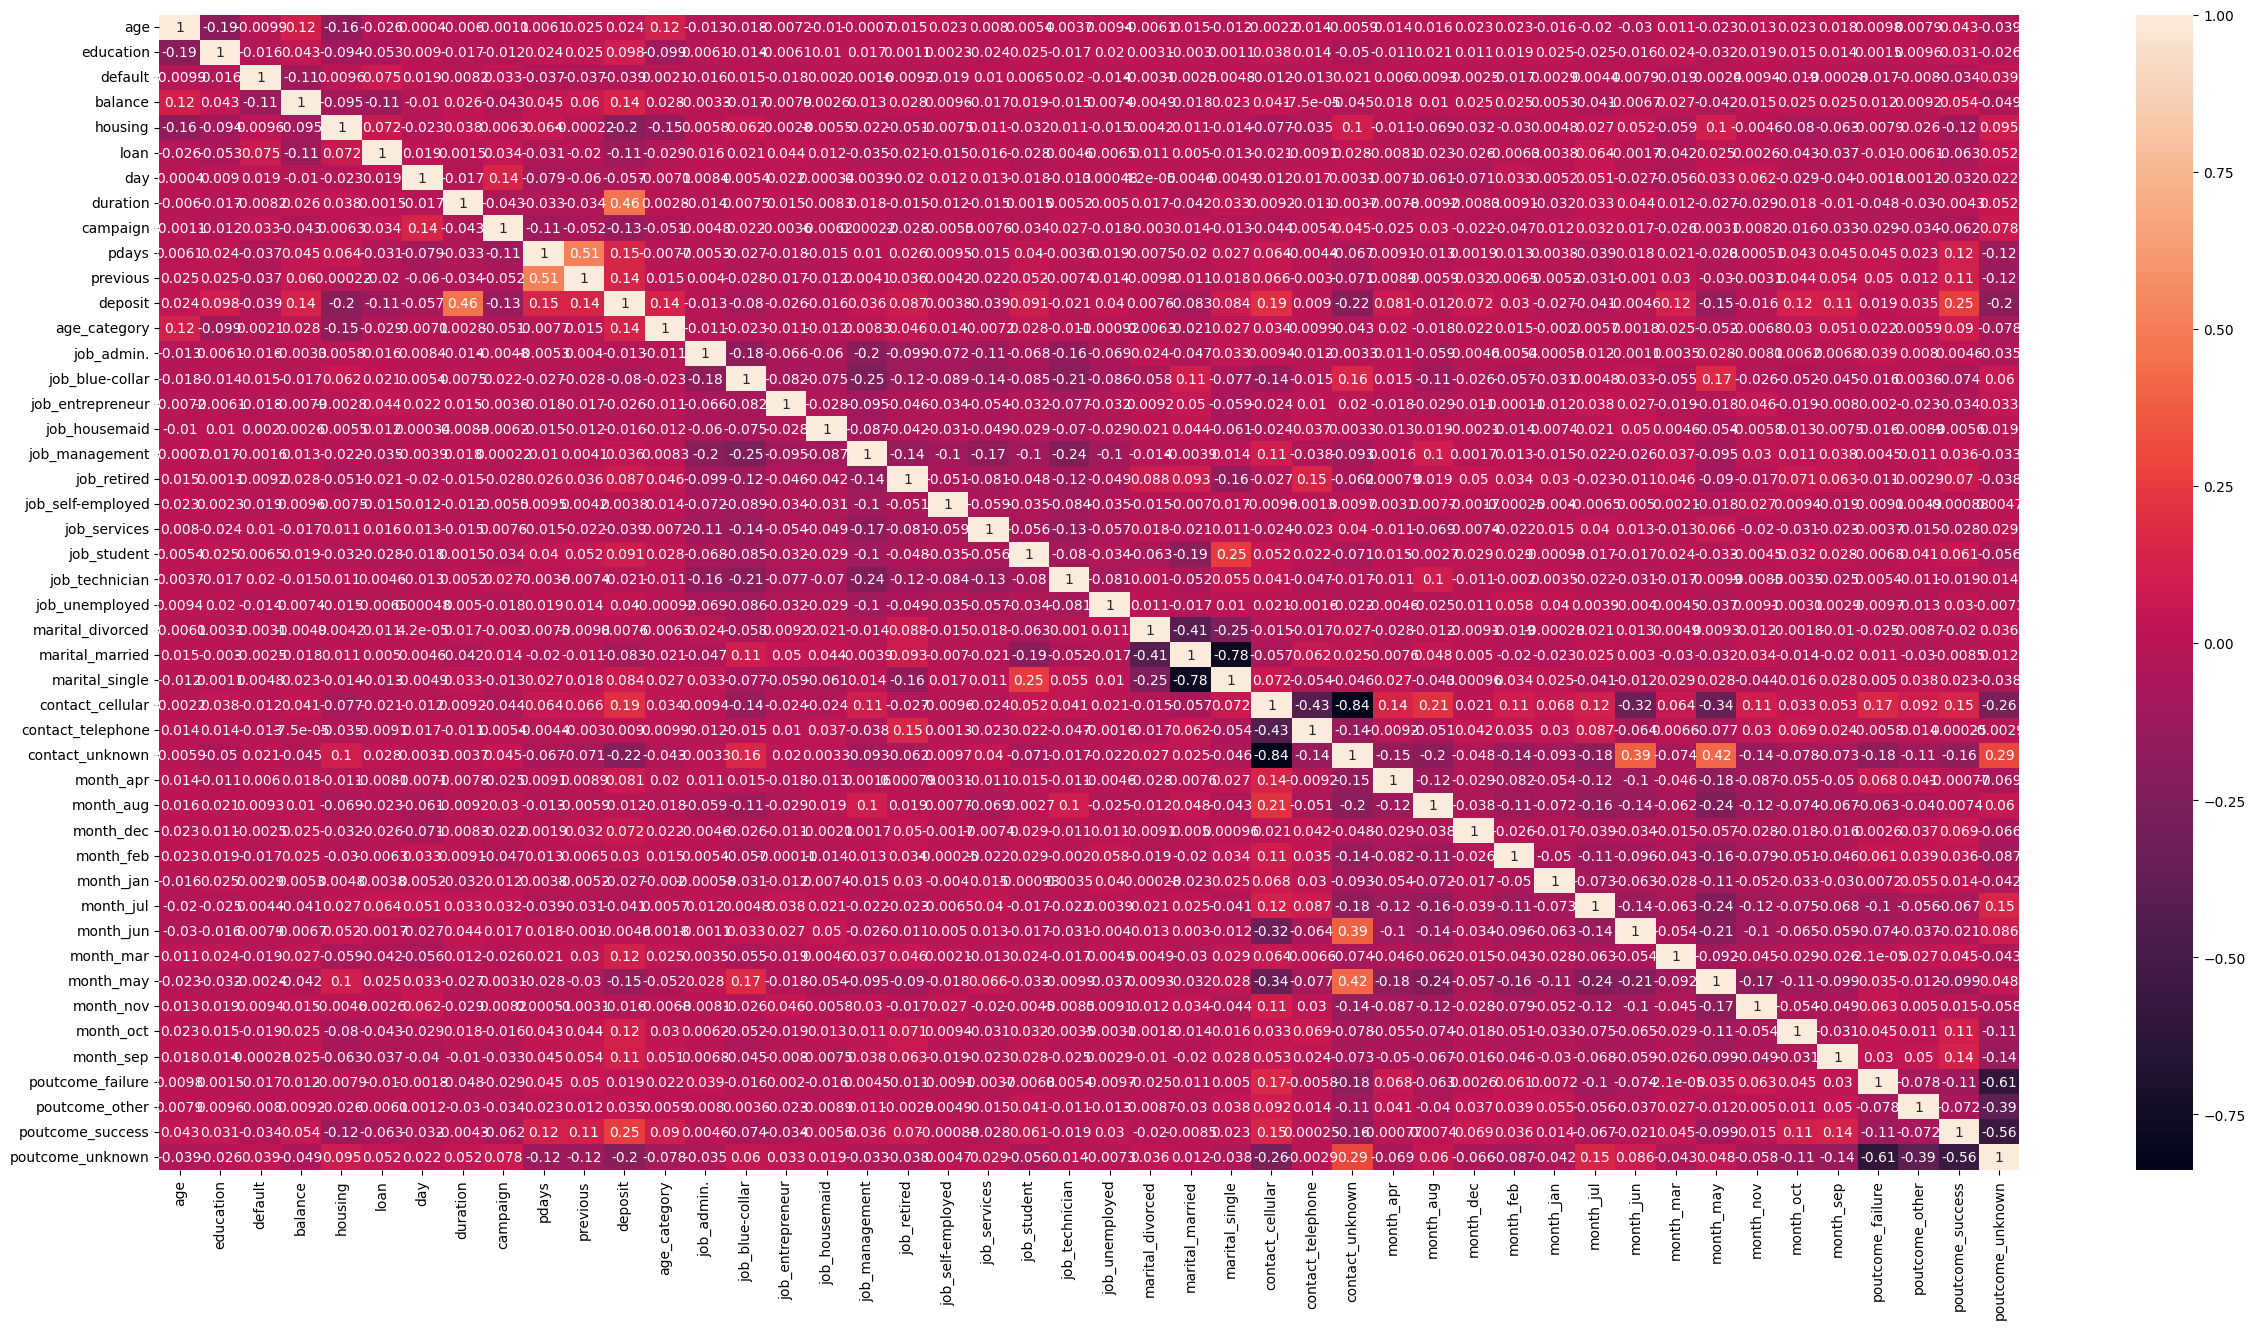

In [81]:
plt.figure(figsize=(30,15))
sns.heatmap(data_cleaned.corr(numeric_only=True), annot = True);


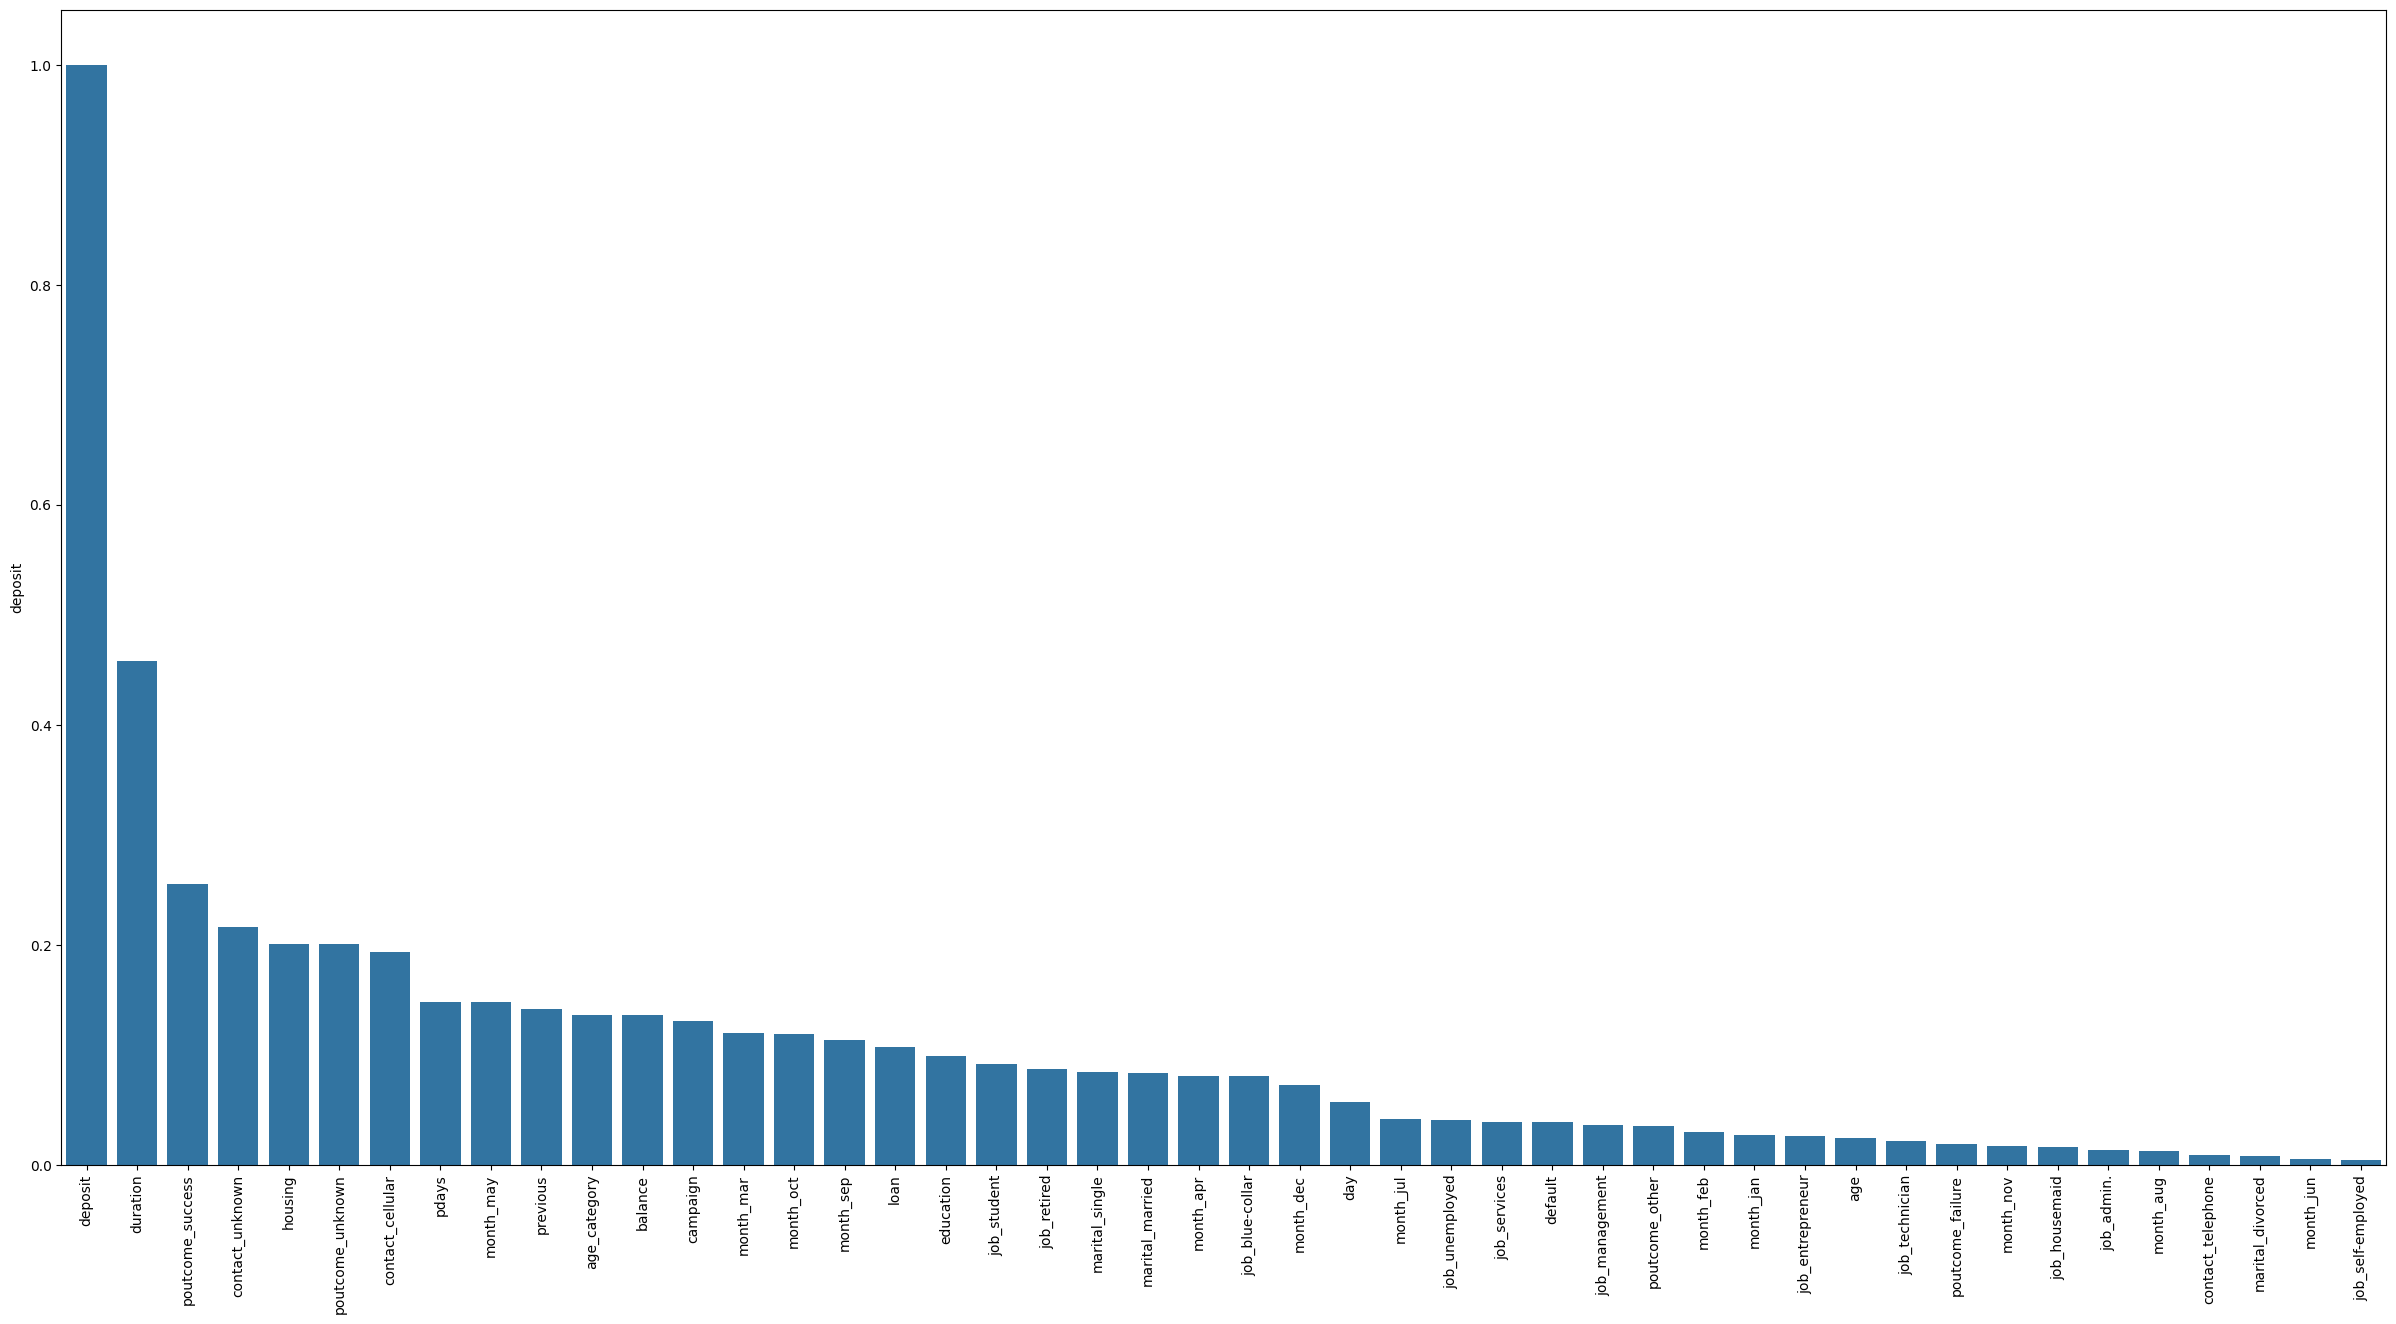

In [94]:
plt.figure(figsize=(30,15));
correliation = abs(data_cleaned.corr(numeric_only=True)['deposit']).sort_values(ascending=False)
sns.barplot(correliation);
plt.xticks(rotation=90);


In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna